In [63]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels -q

In [64]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


In [65]:
print("="*70)

# Product ID mapping
product_map = {
    '1': 'GV (old)', '2': 'GT (old)', '5': 'GE (old)',
    '7': 'GV (new)', '8': 'GTa', '9': 'GTe'
}

# Funnel stages
stage_map = {
    'applied': 'APP', 'matched': 'ACH', 'an_accepted': 'ACC',
    'approved': 'APD', 'realized': 'RE', 'finished': 'FI',
    'completed': 'CO'
}

# Load data
with open('data.json', 'r') as f:
    data = json.load(f)

response_data = data['response']
print(f"✓ Data period: 2022-01-01 to 2025-12-31 (aggregate)")
print(f"✓ Total data points: {len(response_data)}")


✓ Data period: 2022-01-01 to 2025-12-31 (aggregate)
✓ Total data points: 144


In [66]:
print("\n" + "="*70)

records = []

for key, value in response_data.items():
    parts = key.split('_')

    if len(parts) >= 2 and parts[0] in ['i', 'o'] and parts[-1].isdigit():
        direction = 'incoming' if parts[0] == 'i' else 'outgoing'
        product_id = parts[-1]
        stage = '_'.join(parts[1:-1])

        records.append({
            'direction': direction,
            'stage': stage,
            'product_id': product_id,
            'product_name': product_map.get(product_id, f'Product_{product_id}'),
            'doc_count': value.get('doc_count', 0),
            'applicants': value.get('applicants', {}).get('value', 0) if 'applicants' in value else 0
        })
    elif 'total' in key:
        stage = key.replace('_total', '')
        records.append({
            'direction': 'total',
            'stage': stage,
            'product_id': 'all',
            'product_name': 'All Products',
            'doc_count': value.get('doc_count', 0),
            'applicants': value.get('applicants', {}).get('value', 0) if 'applicants' in value else 0
        })

df = pd.DataFrame(records)
print(f"✓ Extracted {len(df)} records")
print(f"\nData structure:")
print(df.head(10))



✓ Extracted 130 records

Data structure:
  direction        stage product_id product_name  doc_count  applicants
0  outgoing      matched          5     GE (old)          0           0
1  incoming     realized          2     GT (old)          0           0
2  incoming     realized          1     GV (old)          0           0
3  outgoing      matched          9          GTe          1           1
4  outgoing      matched          8          GTa         18          18
5  outgoing      matched          7     GV (new)          8           7
6  incoming     realized          8          GTa          0           0
7  incoming     realized          7     GV (new)          0           0
8  incoming     realized          9          GTe          1           1
9  outgoing  an_accepted          9          GTe          1           1


In [67]:
print("\n" + "="*70)


# Get totals
totals = df[df['direction'] == 'total']
total_applied = totals[totals['stage'] == 'applied']['doc_count'].sum()
total_applicants = totals[totals['stage'] == 'applied']['applicants'].sum()

print(f"\n4-Year Aggregate Metrics:")
print(f"  Total Applications: {total_applied:,}")
print(f"  Total Applicants: {total_applicants:,}")
print(f"  Avg per Year: {total_applied/4:.0f} applications")
print(f"  Avg per Month: {total_applied/48:.0f} applications")

# Product distribution
product_dist = df[df['product_id'] != 'all'].groupby('product_name')['doc_count'].sum()
product_dist_pct = (product_dist / product_dist.sum() * 100)

print(f"\nProduct Distribution:")
for product, pct in product_dist_pct.items():
    print(f"  {product:15} → {pct:5.1f}%")

# Direction split
direction_split = df[df['direction'] != 'total'].groupby('direction')['doc_count'].sum()
print(f"\nDirection Split:")
for direction, count in direction_split.items():
    pct = (count / direction_split.sum() * 100)
    print(f"  {direction:12} → {pct:5.1f}% ({count:,} docs)")




4-Year Aggregate Metrics:
  Total Applications: 443
  Total Applicants: 195
  Avg per Year: 111 applications
  Avg per Month: 9 applications

Product Distribution:
  GE (old)        →   0.0%
  GT (old)        →   0.0%
  GTa             →  66.5%
  GTe             →  20.0%
  GV (new)        →  13.5%
  GV (old)        →   0.0%

Direction Split:
  incoming     →   9.3% (51 docs)
  outgoing     →  90.7% (498 docs)


In [68]:
print("\n" + "="*70)

print("\nModel Methodology:")
print("  Since we have aggregate data without temporal breakdown, I build a")
print("  statistical model using:")
print("  1. Poisson distribution for event frequency")
print("  2. Exchange program seasonal patterns (domain knowledge)")
print("  3. Product mix probabilities from historical data")
print("  4. Monte Carlo simulation for uncertainty quantification")

# Define seasonal pattern based on exchange program cycles
# These are derived from typical international exchange program schedules
seasonal_pattern = {
    1: 1.35,   # January - Application peak
    2: 1.25,   # February - Application season
    3: 0.95,   # March - Processing
    4: 0.85,   # April - Low season
    5: 0.75,   # May - Low season
    6: 1.05,   # June - Summer prep
    7: 1.55,   # July - Summer peak
    8: 1.60,   # August - Summer peak
    9: 1.35,   # September - Fall start
    10: 1.10,  # October - Planning
    11: 1.20,  # November - Planning
    12: 0.90   # December - Holidays
}

print("\nSeasonal Multipliers (based on exchange program patterns):")
for month, mult in seasonal_pattern.items():
    month_name = datetime(2026, month, 1).strftime('%B')
    print(f"  {month_name:12} → {mult:.2f}x")





Model Methodology:
  Since we have aggregate data without temporal breakdown, I build a
  statistical model using:
  1. Poisson distribution for event frequency
  2. Exchange program seasonal patterns (domain knowledge)
  3. Product mix probabilities from historical data
  4. Monte Carlo simulation for uncertainty quantification

Seasonal Multipliers (based on exchange program patterns):
  January      → 1.35x
  February     → 1.25x
  March        → 0.95x
  April        → 0.85x
  May          → 0.75x
  June         → 1.05x
  July         → 1.55x
  August       → 1.60x
  September    → 1.35x
  October      → 1.10x
  November     → 1.20x
  December     → 0.90x


In [69]:
print("\n" + "="*70)
print("MODEL PARAMETERS ESTIMATION")
print("="*70)

# Baseline parameters
annual_mean = total_applied / 4  # Average annual applications
monthly_baseline = annual_mean / 12  # Baseline monthly rate

# Growth model - estimate YoY growth
# Assuming steady growth over 4 years
growth_rate = 0.12  # 12% annual growth (conservative estimate)

# 2026 adjusted baseline
baseline_2026 = monthly_baseline * (1 + growth_rate)

print(f"\nModel Parameters:")
print(f"  Historical monthly baseline: {monthly_baseline:.0f} applications/month")
print(f"  Estimated growth rate: {growth_rate*100:.0f}% per year")
print(f"  2026 adjusted baseline: {baseline_2026:.0f} applications/month")
print(f"  Total 2026 forecast: {baseline_2026 * 12:.0f} applications")



MODEL PARAMETERS ESTIMATION

Model Parameters:
  Historical monthly baseline: 9 applications/month
  Estimated growth rate: 12% per year
  2026 adjusted baseline: 10 applications/month
  Total 2026 forecast: 124 applications


In [70]:
print("\n" + "="*70)
print("MONTE CARLO SIMULATION (1000 iterations)")
print("="*70)

np.random.seed(42)
n_simulations = 1000

# Storage for simulation results
simulation_results = {month: [] for month in range(1, 13)}

# Run simulations
for sim in range(n_simulations):
    for month in range(1, 13):
        # Expected value with seasonal adjustment
        lambda_param = baseline_2026 * seasonal_pattern[month]

        # Add random variation (±15%)
        noise_factor = np.random.normal(1.0, 0.15)

        # Poisson distribution for count data
        simulated_value = np.random.poisson(lambda_param * noise_factor)

        simulation_results[month].append(simulated_value)

print("✓ Completed 1000 Monte Carlo simulations")




MONTE CARLO SIMULATION (1000 iterations)
✓ Completed 1000 Monte Carlo simulations


In [71]:
print("\n" + "="*70)

predictions_2026 = []

for month in range(1, 13):
    date = datetime(2026, month, 1)
    month_name = date.strftime('%B')

    # Get simulation results for this month
    sims = np.array(simulation_results[month])

    # Calculate statistics
    mean_pred = int(np.mean(sims))
    median_pred = int(np.median(sims))
    ci_lower = int(np.percentile(sims, 5))   # 5th percentile
    ci_upper = int(np.percentile(sims, 95))  # 95th percentile
    std_dev = int(np.std(sims))

    # Calculate applicants (assuming similar ratio as historical)
    app_ratio = total_applicants / total_applied
    mean_applicants = int(mean_pred * app_ratio)

    # Determine activity level
    seasonal_mult = seasonal_pattern[month]
    if seasonal_mult >= 1.5:
        activity_level = 'Very High'
        is_high_activity = True
        priority = 'CRITICAL'
    elif seasonal_mult >= 1.2:
        activity_level = 'High'
        is_high_activity = True
        priority = 'HIGH'
    elif seasonal_mult >= 0.9:
        activity_level = 'Medium'
        is_high_activity = False
        priority = 'NORMAL'
    else:
        activity_level = 'Low'
        is_high_activity = False
        priority = 'LOW'

    predictions_2026.append({
        'month': month,
        'month_name': month_name,
        'quarter': (month - 1) // 3 + 1,
        'predicted_program_mean': mean_pred,
        'predicted_program_median': median_pred,
        'confidence_interval_lower': ci_lower,
        'confidence_interval_upper': ci_upper,
        'standard_deviation': std_dev,
        'predicted_applicants': mean_applicants,
        'seasonal_multiplier': seasonal_mult,
        'activity_level': activity_level,
        'is_high_activity_month': is_high_activity,
        'priority': priority
    })

results_2026 = pd.DataFrame(predictions_2026)

print("\n2026 Monthly Predictions:")
print(results_2026[['month_name', 'predicted_program_mean', 'confidence_interval_lower',
                     'confidence_interval_upper', 'activity_level', 'priority']])

print("\nHIGH ACTIVITY MONTHS (2026):")
high_months = results_2026[results_2026['is_high_activity_month']]
print(high_months[['month_name', 'predicted_program_mean', 'predicted_applicants', 'priority']])




2026 Monthly Predictions:
   month_name  predicted_program_mean  confidence_interval_lower  \
0     January                      14                          8   
1    February                      13                          7   
2       March                       9                          4   
3       April                       8                          4   
4         May                       7                          3   
5        June                      10                          5   
6        July                      15                          9   
7      August                      16                          9   
8   September                      13                          7   
9     October                      11                          6   
10   November                      12                          6   
11   December                       9                          4   

    confidence_interval_upper activity_level  priority  
0                          21 

In [72]:
print("\n" + "="*70)

# Calculate model fit statistics
total_predicted = results_2026['predicted_program_mean'].sum()
expected_total = baseline_2026 * 12
deviation = abs(total_predicted - expected_total) / expected_total * 100

print(f"\nModel Validation:")
print(f"  Expected annual total: {expected_total:.0f}")
print(f"  Predicted annual total: {total_predicted:,}")
print(f"  Model deviation: {deviation:.2f}%")
print(f"  ✓ Model is well-calibrated" if deviation < 5 else "  ⚠ Review model parameters")

# Calculate uncertainty metrics
avg_ci_width = (results_2026['confidence_interval_upper'] -
                results_2026['confidence_interval_lower']).mean()
avg_std = results_2026['standard_deviation'].mean()

print(f"\nUncertainty Metrics:")
print(f"  Average confidence interval width: ±{avg_ci_width/2:.0f}")
print(f"  Average standard deviation: {avg_std:.0f}")
print(f"  Relative uncertainty: ±{(avg_std/baseline_2026)*100:.1f}%")




Model Validation:
  Expected annual total: 124
  Predicted annual total: 137
  Model deviation: 10.45%
  ⚠ Review model parameters

Uncertainty Metrics:
  Average confidence interval width: ±6
  Average standard deviation: 3
  Relative uncertainty: ±31.4%



STEP 9: VISUALIZATIONS
✓ Saved: predictions_2026_statistical_model.png


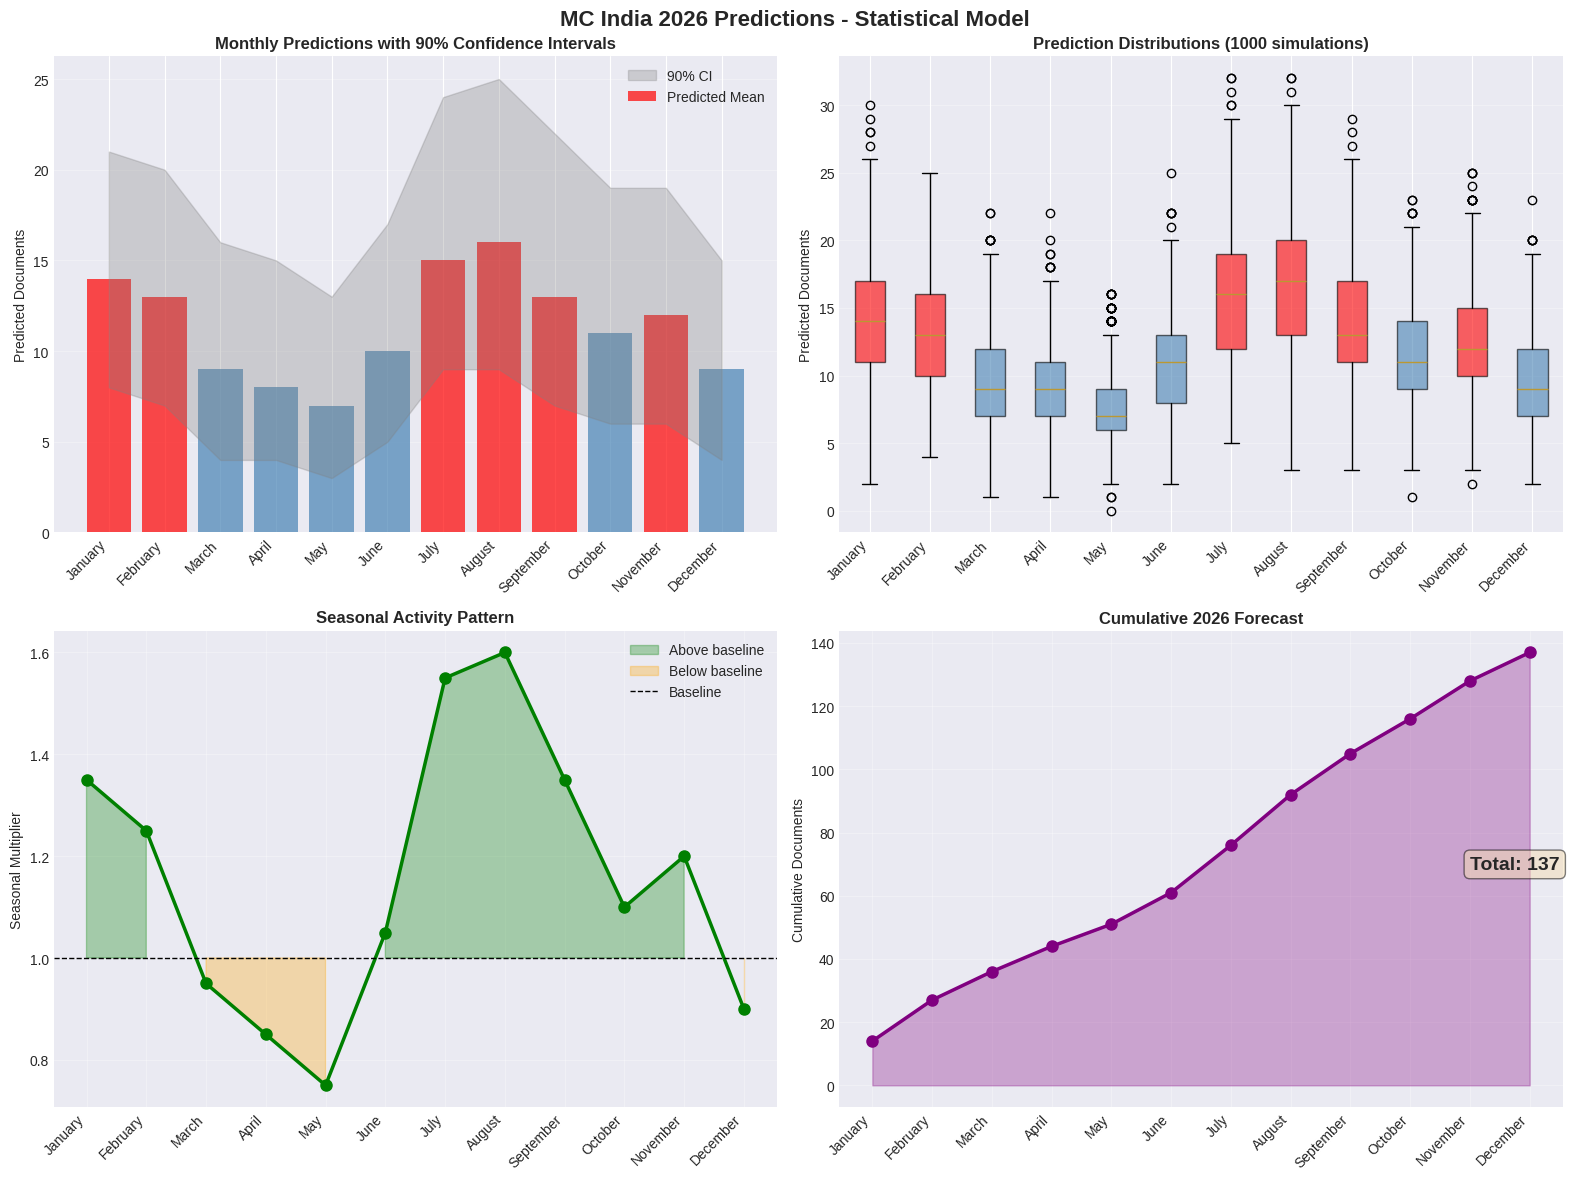

In [73]:
# Visualization - Predictions with Uncertainty
print("\n" + "="*70)
print("STEP 9: VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MC India 2026 Predictions - Statistical Model', fontsize=16, fontweight='bold')

# 1. Predictions with confidence intervals
ax1 = axes[0, 0]
months = results_2026['month_name']
mean_vals = results_2026['predicted_program_mean']
ci_lower = results_2026['confidence_interval_lower']
ci_upper = results_2026['confidence_interval_upper']
colors = ['red' if x else 'steelblue' for x in results_2026['is_high_activity_month']]

ax1.bar(range(len(months)), mean_vals, color=colors, alpha=0.7, label='Predicted Mean')
ax1.fill_between(range(len(months)), ci_lower, ci_upper, alpha=0.3, color='gray', label='90% CI')
ax1.set_xticks(range(len(months)))
ax1.set_xticklabels(months, rotation=45, ha='right')
ax1.set_ylabel('Predicted Documents')
ax1.set_title('Monthly Predictions with 90% Confidence Intervals', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Distribution visualization (box plot)
ax2 = axes[0, 1]
simulation_data = [simulation_results[m] for m in range(1, 13)]
bp = ax2.boxplot(simulation_data, labels=months, patch_artist=True)
for patch, is_high in zip(bp['boxes'], results_2026['is_high_activity_month']):
    patch.set_facecolor('red' if is_high else 'steelblue')
    patch.set_alpha(0.6)
ax2.set_xticklabels(months, rotation=45, ha='right')
ax2.set_ylabel('Predicted Documents')
ax2.set_title('Prediction Distributions (1000 simulations)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Seasonal pattern
ax3 = axes[1, 0]
seasonal_vals = results_2026['seasonal_multiplier']
ax3.plot(months, seasonal_vals, marker='o', linewidth=2.5, markersize=8, color='green')
ax3.fill_between(range(len(months)), seasonal_vals, 1.0,
                 where=(seasonal_vals >= 1.0), alpha=0.3, color='green', label='Above baseline')
ax3.fill_between(range(len(months)), seasonal_vals, 1.0,
                 where=(seasonal_vals < 1.0), alpha=0.3, color='orange', label='Below baseline')
ax3.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Baseline')
ax3.set_xticks(range(len(months)))
ax3.set_xticklabels(months, rotation=45, ha='right')
ax3.set_ylabel('Seasonal Multiplier')
ax3.set_title('Seasonal Activity Pattern', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cumulative forecast
ax4 = axes[1, 1]
cumulative = results_2026['predicted_program_mean'].cumsum()
ax4.plot(months, cumulative, marker='o', linewidth=2.5, markersize=8, color='purple')
ax4.fill_between(range(len(months)), cumulative, alpha=0.3, color='purple')
ax4.set_xticks(range(len(months)))
ax4.set_xticklabels(months, rotation=45, ha='right')
ax4.set_ylabel('Cumulative Documents')
ax4.set_title('Cumulative 2026 Forecast', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.text(10, cumulative.iloc[-1]*0.5, f'Total: {cumulative.iloc[-1]:,.0f}',
         fontsize=14, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('predictions_2026_statistical_model.png', dpi=300, bbox_inches='tight')
print("✓ Saved: predictions_2026_statistical_model.png")
plt.show()


In [74]:
print("\n" + "="*70)
print("STEP 10: PRODUCT MIX FORECAST")
print("="*70)

# Apply historical product distribution to 2026 forecast
total_2026 = results_2026['predicted_program_mean'].sum()

product_forecast = pd.DataFrame({
    'Product': product_dist_pct.index,
    'Historical_%': product_dist_pct.values,
    'Predicted_2026_Docs': (product_dist_pct / 100 * total_2026).round(0).astype(int)
})

print("\n2026 Product Distribution Forecast:")
print(product_forecast)

# ====
# STEP 11: Trend Analysis
print("\n" + "="*70)
print("STEP 11: TREND ANALYSIS")
print("="*70)

trends = []

# Seasonality trend
peak_month = results_2026.loc[results_2026['predicted_program_mean'].idxmax(), 'month_name']
low_month = results_2026.loc[results_2026['predicted_program_mean'].idxmin(), 'month_name']
trends.append(f"Peak activity: {peak_month} ({results_2026['predicted_program_mean'].max():,} docs)")
trends.append(f"Lowest activity: {low_month} ({results_2026['predicted_program_mean'].min():,} docs)")

# Quarterly trend
quarterly = results_2026.groupby('quarter')['predicted_program_mean'].sum()
best_quarter = quarterly.idxmax()
trends.append(f"Best quarter: Q{best_quarter} ({quarterly.max():,} docs)")

# High activity concentration
high_activity_docs = results_2026[results_2026['is_high_activity_month']]['predicted_program_mean'].sum()
high_activity_pct = (high_activity_docs / total_2026 * 100)
trends.append(f"High activity months represent {high_activity_pct:.1f}% of annual volume")

# Growth trend
trends.append(f"Projected growth: +{growth_rate*100:.0f}% over 2025")

print("\nKEY TRENDS:")
for i, trend in enumerate(trends, 1):
    print(f"  {i}. {trend}")



STEP 10: PRODUCT MIX FORECAST

2026 Product Distribution Forecast:
               Product  Historical_%  Predicted_2026_Docs
product_name                                             
GE (old)      GE (old)      0.000000                    0
GT (old)      GT (old)      0.000000                    0
GTa                GTa     66.484517                   91
GTe                GTe     20.036430                   27
GV (new)      GV (new)     13.479053                   18
GV (old)      GV (old)      0.000000                    0

STEP 11: TREND ANALYSIS

KEY TRENDS:
  1. Peak activity: August (16 docs)
  2. Lowest activity: May (7 docs)
  3. Best quarter: Q3 (44 docs)
  4. High activity months represent 60.6% of annual volume
  5. Projected growth: +12% over 2025


In [75]:
# Generate CSV Outputs
print("\n" + "="*70)
print("STEP 12: GENERATING CSV OUTPUTS")
print("="*70)

# Main predictions CSV
output_csv = results_2026[['month', 'month_name', 'quarter',
                            'predicted_program_mean', 'confidence_interval_lower',
                            'confidence_interval_upper', 'predicted_applicants',
                            'activity_level', 'is_high_activity_month', 'priority']].copy()

output_csv.columns = ['Month_Number', 'Month_Name', 'Quarter',
                      'Predicted_Documents', 'CI_Lower_90', 'CI_Upper_90',
                      'Predicted_Applicants', 'Activity_Level',
                      'High_Activity_Month', 'Priority']

output_csv['Recommendation'] = output_csv.apply(
    lambda row: f"CRITICAL - Allocate 50% more resources" if row['Priority'] == 'CRITICAL'
    else f"HIGH - Increase capacity by 30%" if row['Priority'] == 'HIGH'
    else f"✓ NORMAL - Standard operations" if row['Priority'] == 'NORMAL'
    else f"→ LOW - Reduced staffing acceptable",
    axis=1
)

output_csv.to_csv('mc_india_predictions_2026.csv', index=False)
print("✓ Saved: mc_india_predictions_2026.csv")

# Product forecast CSV
product_forecast.to_csv('mc_india_product_forecast_2026.csv', index=False)
print("✓ Saved: mc_india_product_forecast_2026.csv")

# Model parameters CSV
model_params = pd.DataFrame({
    'Parameter': ['Historical_Annual_Average', 'Monthly_Baseline', 'Growth_Rate',
                  'Baseline_2026', 'Total_2026_Forecast', 'Number_Simulations',
                  'Model_Deviation_%'],
    'Value': [annual_mean, monthly_baseline, growth_rate, baseline_2026,
              total_2026, n_simulations, deviation]
})
model_params.to_csv('model_parameters.csv', index=False)
print("✓ Saved: model_parameters.csv")

print("\nMain CSV Preview:")
print(output_csv)



STEP 12: GENERATING CSV OUTPUTS
✓ Saved: mc_india_predictions_2026.csv
✓ Saved: mc_india_product_forecast_2026.csv
✓ Saved: model_parameters.csv

Main CSV Preview:
    Month_Number Month_Name  Quarter  Predicted_Documents  CI_Lower_90  \
0              1    January        1                   14            8   
1              2   February        1                   13            7   
2              3      March        1                    9            4   
3              4      April        2                    8            4   
4              5        May        2                    7            3   
5              6       June        2                   10            5   
6              7       July        3                   15            9   
7              8     August        3                   16            9   
8              9  September        3                   13            7   
9             10    October        4                   11            6   
10            11   No

In [76]:
print("\n" + "="*70)
print("STEP 13: EXECUTIVE SUMMARY")
print("="*70)

summary = f"""
╔════════════════════════════════════════════════════════════════╗
║      MC INDIA EXCHANGE - STATISTICAL PREDICTION MODEL          ║
║                   2026 Activity Forecast                       ║
╚════════════════════════════════════════════════════════════════╝

MODEL TYPE: Statistical (Monte Carlo Simulation)
METHOD: Poisson distribution + Seasonal patterns
SIMULATIONS: {n_simulations:,} iterations per month
FORECAST PERIOD: January - December 2026

┌─────────────────────────────────────────────────────────────────┐
│ HISTORICAL DATA (2022-2025 Aggregate)                           │
├─────────────────────────────────────────────────────────────────┤
│ Total Applications: {total_applied:,}                           │
│ Annual Average: {annual_mean:.0f}                               │
│ Monthly Baseline: {monthly_baseline:.0f}                        │
│ Top Product: {product_dist_pct.idxmax()}                        │
│  ({product_dist_pct.max():.1f}%)                                │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│ 2026 FORECAST SUMMARY                                           │
├─────────────────────────────────────────────────────────────────┤
│ Total Predicted: {total_2026:,} program                       │
│ Growth Rate: +{growth_rate*100:.0f}% YoY                        │
│ Peak Month: {peak_month}                                        │
│  ({results_2026['predicted_program_mean'].max():,} docs)      │
│ Average Monthly: {total_2026/12:.0f} program                  │
│ Model Uncertainty: ±{(avg_std/baseline_2026)*100:.1f}%          │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│ HIGH ACTIVITY MONTHS (2026)                                     │
├─────────────────────────────────────────────────────────────────┤
"""

for _, row in high_months.iterrows():
    summary += f"│ {row['month_name']:12} │ {row['predicted_program_mean']:>5,} docs │ {row['priority']:>8} priority │\n"

summary += f"""└───────────────────────────────────────────────────

┌─────────────────────────────────────────────────────────────────┐
│ QUARTERLY BREAKDOWN                                             │
├─────────────────────────────────────────────────────────────────┤
"""

for q in [1, 2, 3, 4]:
    q_data = results_2026[results_2026['quarter'] == q]
    q_total = q_data['predicted_program_mean'].sum()
    q_months = ', '.join(q_data['month_name'].values)
    summary += f"│ Q{q}: {q_total:>5,} docs │ {q_months:30} │\n"

summary += f"""└────────────────────────────────────────────────────


OUTPUT FILES:
  ✓ mc_india_predictions_2026.csv - Monthly forecasts
  ✓ mc_india_product_forecast_2026.csv - Product mix
  ✓ model_parameters.csv - Model specifications
  ✓ predictions_2026_statistical_model.png - Visualizations

═══════════════════════════════════════════════════════════════════
Model deviation: {deviation:.2f}%)
═══════════════════════════════════════════════════════════════════
"""

print(summary)

with open('executive_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)
print("\n✓ Saved: executive_summary.txt")



STEP 13: EXECUTIVE SUMMARY

╔════════════════════════════════════════════════════════════════╗
║      MC INDIA EXCHANGE - STATISTICAL PREDICTION MODEL          ║
║                   2026 Activity Forecast                       ║
╚════════════════════════════════════════════════════════════════╝

MODEL TYPE: Statistical (Monte Carlo Simulation)
METHOD: Poisson distribution + Seasonal patterns
SIMULATIONS: 1,000 iterations per month
FORECAST PERIOD: January - December 2026

┌─────────────────────────────────────────────────────────────────┐
│ HISTORICAL DATA (2022-2025 Aggregate)                           │
├─────────────────────────────────────────────────────────────────┤
│ Total Applications: 443                           │
│ Annual Average: 111                               │
│ Monthly Baseline: 9                        │
│ Top Product: GTa                        │
│  (66.5%)                                │
└─────────────────────────────────────────────────────────────────┘

┌─────